## This Notebook will aim to Optimize linear Models

I have a lot of different automatic results in the previous notebook so just manually take most optimal features and reduce from there



## Start with Naive Bayes


'avg3Months_Loan', 'avg3Months_DebtCollection', 'avg6Months_Loan', 'avg6Months_Gambling', 'avg_Gambling', 'avg_Salary', 'avg3Months_Deposit', 'avg3Months_Gambling','avg_Loan', 'avg_HousingCost', 'avg3Months_CashWithdrawal' ,'avg6Months_DirectDebit', 'avg_Gaming', 'avg3Months_Gaming', 'avg_CashWithdrawal', 'avg_OtherIncome', 'avg6Months_CashWithdrawal', 'avg6Months_InstallmentPayment', 'avg_DirectDebit', 'avg6Months_HousingCost', 'avg6Months_Gaming', 'avg3Months_DirectDebit'
'count_Loan', 'trend_DebtCollection', 'sum_Loan', 'trend_Deposit', 'sum_Gambling', 'count_Gambling', 'sum_Salary', 'trend_CashWithdrawal', 'sum_DirectDebit',

'sum installmentPayments', 'trend_Loan', 'Gambling_sum9Months', 'MoneyRemittance_monthlyAvg','trend_Salary', 'MoneyRemittance_partOfSalary9Months', 'Gambling_sum12Months', 'trend_MoneyRemittance', 'Crypto_count3Months', 'trend_OtherIncome', 'trend_PassiveIncome', 'Gambling_count9Months', 'Gambling_partOfSalary3Months', 'MoneyRemittance_category',

'DebtCollection_count9Months', 'CashWithdrawal_sum3Months'

'DebtCollection_sum3Months', 'DebtCollection_sum9Months', 'InstallmentPayment_count12Months', 'DebtCollection_partOfSalary12Months', 'DebtCollection_sum12Months', 'InstallmentPayment_count9Months',



In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])



In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()




In [4]:
# df= df.iloc[:,:200]

In [5]:

# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')


In [6]:


preprocessor = DataPreprocessor(df)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',

input = df[['Ever90'] +list(all_features) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)

input_dim = Xtrain.shape[1]

## Reduce dataset based on BRFS of RF as input into DL

In [7]:
selected = ['avg_Loan', 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg3Months_Salary',
       'avg6Months_Gambling', 'avg6Months_HousingCost',
       'avg6Months_Salary', 'count_Loan', 'sum_Salary', 'trend_Gaming',
       'trend_MobilePayment', 'Gambling_category', 'Gambling_sum12Months',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'Gaming_count3Months', 'MobilePayment_partOfSalary6Months',
       'DebtCollection_count12Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_sum3Months']

       

In [8]:
S_selected = selected #[:40]

In [10]:


input = df[['Ever90'] +list(S_selected) ]

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  all_features)
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

# Custom Gini scorer
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Define the Naive Bayes model with smoothing parameter
naive_bayes = GaussianNB(var_smoothing=1e-9)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(naive_bayes, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(selected)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
naive_bayes.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(naive_bayes, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the datasets using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)

# Predict probabilities
y_train_pred_proba = naive_bayes.predict_proba(X_train_optimal)[:, 1]
y_val_pred_proba = naive_bayes.predict_proba(X_val_optimal)[:, 1]
y_test_pred_proba = naive_bayes.predict_proba(X_test_optimal)[:, 1]

# Concatenate the prediction probabilities
all_y_true = np.concatenate([Ytrain, Yval, Ytest])
all_y_pred_proba = np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])


# Plot the ROC curves
plot_gini(naive_bayes, X_train_optimal, Ytrain, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")


/Users/andreasnilsson/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/andreasnilsson/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/andreasnilsson/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/Users/andreasnilsson/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/Users/andreasnilsson/Library/Python/3.9/lib/python/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in 

In [14]:

selected = ['avg_Loan', 'avg_Salary', 'avg3Months_CashWithdrawal',
       'avg3Months_Deposit', 'avg3Months_Loan', 'avg3Months_Salary',
       'avg6Months_Gambling', 'avg6Months_HousingCost',
       'avg6Months_Salary', 'count_Loan', 'sum_Salary', 'trend_Gaming',
       'trend_MobilePayment', 'Gambling_category', 'Gambling_sum12Months',
       'CashWithdrawal_sum12Months', 'CashWithdrawal_sum6Months',
       'Gaming_count3Months', 'MobilePayment_partOfSalary6Months',
       'DebtCollection_count12Months', 'DebtCollection_sum12Months',
       'InstallmentPayment_count12Months',
       'InstallmentPayment_partOfSalary12Months',
       'HousingCost_count6Months', 'HousingCost_partOfSalary3Months',
       'DirectDebit_sum12Months', 'Unclassified_sum3Months']


       
input = df[['Ever90'] +list(selected) ]

preprocessor = DataPreprocessor(input)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',



## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  selected)


# Define the Naive Bayes model with smoothing parameter
naive_bayes = GaussianNB(var_smoothing=1e-9)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(naive_bayes, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(selected)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
naive_bayes.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(naive_bayes, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the datasets using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)

# Predict probabilities
y_train_pred_proba = naive_bayes.predict_proba(X_train_optimal)[:, 1]
y_val_pred_proba = naive_bayes.predict_proba(X_val_optimal)[:, 1]
y_test_pred_proba = naive_bayes.predict_proba(X_test_optimal)[:, 1]

# Concatenate the prediction probabilities
all_y_true = np.concatenate([Ytrain, Yval, Ytest])
all_y_pred_proba = np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])


# Plot the ROC curves
plot_gini(naive_bayes, X_train_optimal, Ytrain, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")


Final model Gini coefficient: 0.2713


Final model Gini coefficient: 0.2584


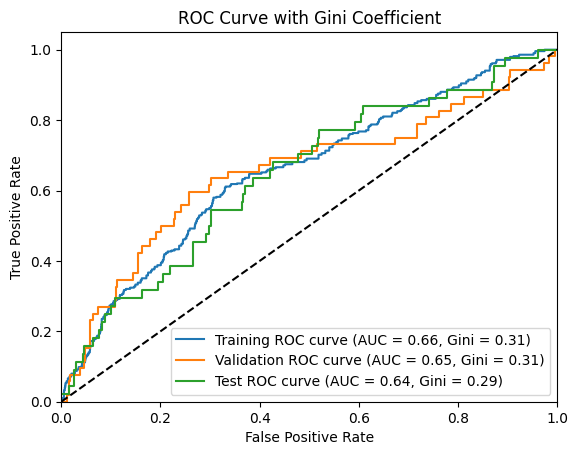

In [ ]:

       selected = [
    'avg_Gambling', 'avg_HousingCost', 'avg_Loan', 'avg_Salary',
    'avg3Months_CashWithdrawal', 'avg3Months_Deposit', 'avg3Months_Loan',
    'avg3Months_MobilePayment', 'avg3Months_Salary', 'avg6Months_Gambling',
    'avg6Months_Gaming', 'avg6Months_HousingCost', 'avg6Months_Loan',
    'avg6Months_MobilePayment', 'avg6Months_Salary', 'count_Gambling',
    'count_InstallmentPayment', 'count_Loan', 'count_MobilePayment',
    'count_PassiveIncome', 'count_Salary', 'sum_Gaming', 'sum_OtherIncome',
    'sum_Salary', 'trend_DebtCollection', 'trend_Deposit', 'trend_Gaming',
    'trend_MobilePayment', 'trend_Salary', 'Gambling_category',
    'Gambling_count6Months', 'Gambling_monthlyAvg', 'Gambling_sum12Months',
    'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months',
    'CashWithdrawal_sum6Months', 'Gaming_count3Months', 'Gaming_count9Months',
    'MobilePayment_count12Months', 'MobilePayment_partOfSalary12Months',
    'MobilePayment_partOfSalary6Months', 'DebtCollection_count12Months',
    'DebtCollection_sum12Months', 'DebtCollection_sum3Months',
    'InstallmentPayment_count12Months', 'InstallmentPayment_monthlyAvg',
    'InstallmentPayment_partOfSalary12Months',
    'InstallmentPayment_partOfSalary9Months', 'InstallmentPayment_sum6Months',
    'HousingCost_count12Months', 'HousingCost_count6Months',
    'HousingCost_partOfSalary3Months', 'DirectDebit_count3Months',
    'DirectDebit_sum12Months', 'DirectDebit_sum3Months',
    'Unclassified_sum3Months'
]


selected = selected[:30]
       
input = df[['Ever90'] +list(selected) ]

preprocessor = DataPreprocessor(input)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',



## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  selected)

# Define the Naive Bayes model with smoothing parameter
naive_bayes = GaussianNB(var_smoothing=1e-9)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(naive_bayes, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(selected)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
naive_bayes.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(naive_bayes, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the datasets using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)

# Predict probabilities
y_train_pred_proba = naive_bayes.predict_proba(X_train_optimal)[:, 1]
y_val_pred_proba = naive_bayes.predict_proba(X_val_optimal)[:, 1]
y_test_pred_proba = naive_bayes.predict_proba(X_test_optimal)[:, 1]

# Concatenate the prediction probabilities
all_y_true = np.concatenate([Ytrain, Yval, Ytest])
all_y_pred_proba = np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])


# Plot the ROC curves
plot_gini(naive_bayes, X_train_optimal, Ytrain, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")


Final model Gini coefficient: 0.2522


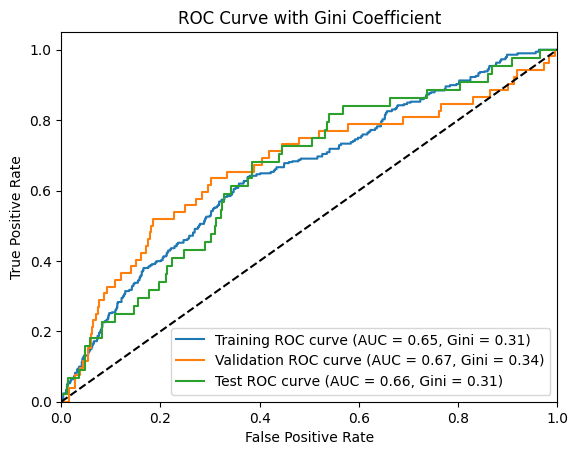

In [24]:

       selected = [
    'avg_Gambling', 'avg_HousingCost', 'avg_Loan', 'avg_Salary',
    'avg3Months_CashWithdrawal', 'avg3Months_Deposit', 'avg3Months_Loan',
    'avg3Months_MobilePayment', 'avg3Months_Salary', 'avg6Months_Gambling',
    'avg6Months_Gaming', 'avg6Months_HousingCost', 'avg6Months_Loan',
    'avg6Months_MobilePayment', 'avg6Months_Salary', 'count_Gambling',
    'count_InstallmentPayment', 'count_Loan', 'count_MobilePayment',
    'count_PassiveIncome', 'count_Salary', 'sum_Gaming', 'sum_OtherIncome',
    'sum_Salary', 'trend_DebtCollection', 'trend_Deposit', 'trend_Gaming',
    'trend_MobilePayment', 'trend_Salary', 'Gambling_category',
    'Gambling_count6Months', 'Gambling_monthlyAvg', 'Gambling_sum12Months',
    'CashWithdrawal_count6Months', 'CashWithdrawal_sum12Months',
    'CashWithdrawal_sum6Months', 'Gaming_count3Months', 'Gaming_count9Months',
    'MobilePayment_count12Months', 'MobilePayment_partOfSalary12Months',
    'MobilePayment_partOfSalary6Months', 'DebtCollection_count12Months',
    'DebtCollection_sum12Months', 'DebtCollection_sum3Months',
    'InstallmentPayment_count12Months', 'InstallmentPayment_monthlyAvg',
    'InstallmentPayment_partOfSalary12Months',
    'InstallmentPayment_partOfSalary9Months', 'InstallmentPayment_sum6Months',
    'HousingCost_count12Months', 'HousingCost_count6Months',
    'HousingCost_partOfSalary3Months', 'DirectDebit_count3Months',
    'DirectDebit_sum12Months', 'DirectDebit_sum3Months',
    'Unclassified_sum3Months'
]


selected = selected[:34]
       
input = df[['Ever90'] +list(selected) ]

preprocessor = DataPreprocessor(input)

all_features = df.drop(columns=['Ever90','ReceivedDate',	'ApplicationID','AccountNumber','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','HasCoapp','NR']).columns ## DROP THESE SINCE THEY ARE JUST IDENTIFIERS   --'_merge',



## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  selected)


import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import RandomOverSampler

# Custom Gini scorer
def gini_score(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

# Define the logistic regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=420)
Xtrain_resampled, Ytrain_resampled = oversampler.fit_resample(Xtrain, Ytrain)

# Define the SequentialFeatureSelector object for forward feature selection
sfs = SequentialFeatureSelector(logreg, direction='forward', scoring=make_scorer(gini_score), cv=StratifiedKFold(3), n_jobs=-1)

# Perform forward feature selection on the resampled data
sfs.fit(Xtrain_resampled, Ytrain_resampled)

# Output the results
optimal_features = np.array(selected)[sfs.get_support()]

# Transform the dataset to the optimal feature set
X_optimal = sfs.transform(Xtrain_resampled)

# Retrain the model with the optimal feature set
logreg.fit(X_optimal, Ytrain_resampled)

# Evaluate the final model
final_score = cross_val_score(logreg, X_optimal, Ytrain_resampled, cv=3, scoring=make_scorer(gini_score))
print("Final model Gini coefficient: %0.4f" % final_score.mean())

# Transform the test set using the selected features
X_train_optimal = sfs.transform(Xtrain)
X_val_optimal = sfs.transform(Xval)
X_test_optimal = sfs.transform(Xtest)


# Plot for both the training and val sets
plot_gini(logreg, X_optimal, Ytrain_resampled, X_val_optimal, Yval, X_test_optimal, Ytest, "ROC Curve with Gini Coefficient")


In [25]:
optimal_features

array(['avg_Gambling', 'avg_Loan', 'avg_Salary', 'avg3Months_Deposit',
       'avg3Months_Loan', 'avg6Months_Gaming', 'avg6Months_Loan',
       'count_Loan', 'sum_OtherIncome', 'trend_DebtCollection',
       'trend_Deposit', 'trend_Gaming', 'trend_MobilePayment',
       'trend_Salary', 'Gambling_category', 'Gambling_monthlyAvg',
       'CashWithdrawal_count6Months'], dtype='<U27')

In [30]:
import joblib

path = "../../2. Python/Finished Models"
os.chdir(path)


In [31]:
import joblib

# Save the model and features
joblib.dump(logreg, os.path.join( 'lg_model_1.pkl'))

joblib.dump(optimal_features, os.path.join('optimal_features_lg_model_1.pkl'))

print("Model and features have been saved to Python/Finished Models.")

Model and features have been saved to Python/Finished Models.
